# NSF - TRIMMing CO2

## Collaboration for 3D printing between WVU's Energy Systems and Materials Simulation (ESMS) group and ULL's Intelligent Manufacturing and Systems Laboratory (IMSL)

Websites:
- ESMS: https://github.com/ESMS-Group-Public/FoKL-GPy
- IMSL: https://sites.google.com/view/drsenliu/home?authuser=0

Using the following paper and its data as an **example to show how FoKL might be used to find optimal inputs for desired outputs (and thereby guiding the next experiment)**:
- https://scholar.google.com/citations?view_op=view_citation&hl=en&user=1W6RBpMAAAAJ&citation_for_view=1W6RBpMAAAAJ:YOwf2qJgpHMC

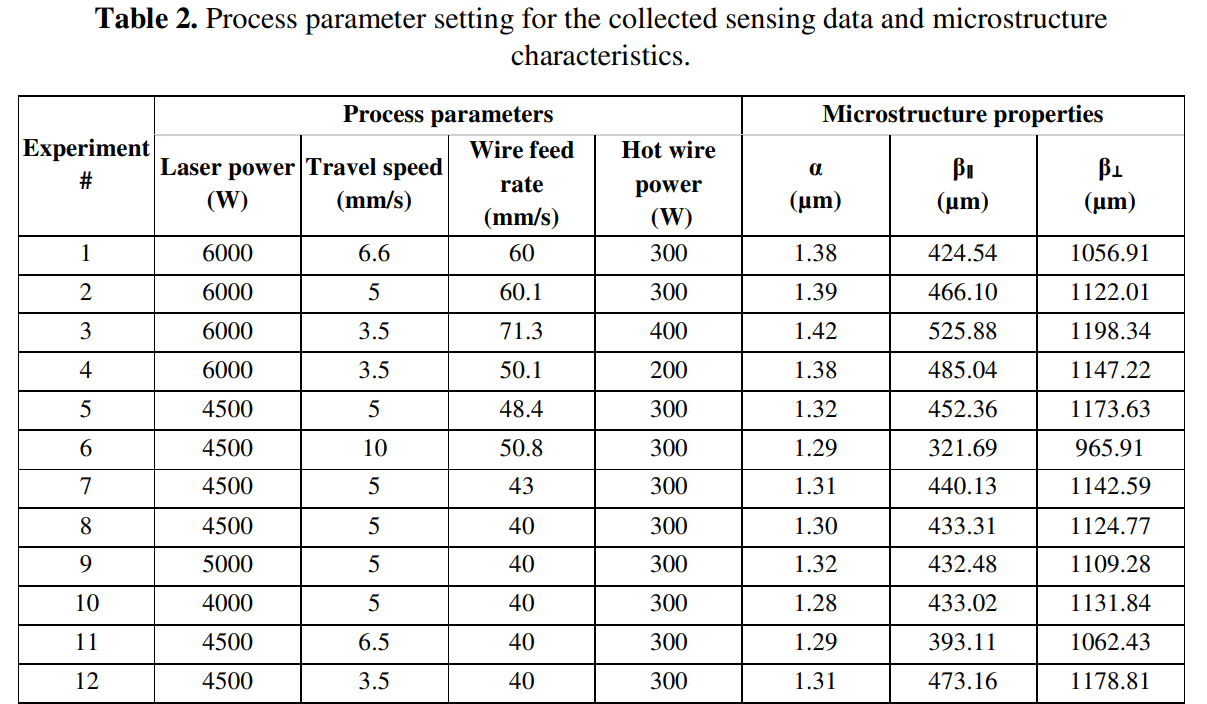

The dataset generated by the first few experiments is:

In [ ]:
LP = [6000, ..., 4500]          # laser power
TS = [6.6, ..., 3.5]            # travel speed
WFR = [60, ..., 40]             # wire feed rate
HWP = [300, ..., 300]           # hot wire power

a = [1.38, ..., 1.31]           # alpha
b = [424.54, ..., 473.16]       # beta (parallel)
b90 = [1056.91, ..., 1178.81]   # beta (perpindicular)

FoKL models can now be trained for each output.

In [ ]:
from FoKL import FoKLRoutines


# Initialize:
model_a = FoKLRoutines.FoKL(kernel=1)
model_b = FoKLRoutines.FoKL(kernel=1)
model_b90 = FoKLRoutines.FoKL(kernel=1)

# Train:
inputs = [LP, TS, WFR, HWP]
model_a.fit(inputs, a, clean=True)
model_b.fit(inputs, b, clean=True)
model_b90.fit(inputs, b90, clean=True)

The trained models can then be converted to Pyomo for nonlinear optimization.

In [ ]:
m = model_a.to_pyomo()  # create Pyomo model with alpha
model_b.to_pyomo(m)     # append beta (perpindicular) to Pyomo model
model_b90.to_pyomo(m)   # append beta (parallel)

Define the objective to solve for (e.g., minimize $\alpha+\beta_{\parallel}+\beta_{\perp}$) Note the variables 'm.a', 'm.b', 'm.b90' all appear as 'm.fokl_y' in the Pyomo model, so naming your Pyomo variables like this is currntly in progress but should be released soon.

In [ ]:
import pyomo.environ as pyo


m.obj = pyo.Objective(expr=sum(m.a[i] + m.b[i] + m.b90[i] for i in m.fokl_scenarios), sense=pyo.minimize)

Initialize nonlinear solver to run from various points to arrive at a global solution:

In [ ]:
solver = pyo.SolverFactory('multistart')

Solve for the optimal inputs:

In [ ]:
solver.solve(m, solver='ipopt')

Retrieve the computation-informed inputs to try for the next experiment:

In [ ]:
sol_LS = m.LS()
sol_TS = m.TS()
sol_WFR = m.WFR()
sol_HWP = m.HWP()

Run new experiment with calculated inputs. Repeat.